# Prophet modeling

Here we'll try to mimic the same process of finding the best train-test split, but for Facebook's Prophet library. Let's import everything.

In [30]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
import pandas as pd
import matplotlib.pyplot as plt
import pandas.tseries
import datetime as dt
from datetime import date
from datetime import timedelta 
import yfinance as yf
import requests
from pandas.plotting import lag_plot
from pandas import datetime
import re
from tiingo import TiingoClient
import json
from pandas_datareader import data as pdr

In [31]:
yf.__version__

'0.1.63'

### The test case: C
Just like the previous notebook, we'll try to run through a simple test case and expand it to other stocks. We'll use Citicgroup again.

Quick note: I encountered a bug with my earlier library, yfinance, so I've had to switch to tiingo, so a lot of code will be hashed out from earlier. And in case I can get the bugs worked out.

In [32]:
c = yf.Ticker("C")

In [33]:
df=c.history(period="2y")

In [34]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-07,63.310645,64.215477,63.301315,63.571835,7835500,0.0,0
2019-10-08,62.527079,62.667004,61.594257,61.939404,13500700,0.0,0
2019-10-09,62.499086,63.217356,62.303194,62.900200,8357800,0.0,0
2019-10-10,63.217372,64.635266,63.012157,64.010277,9817000,0.0,0
2019-10-11,65.288228,66.165083,65.288228,65.390839,14921700,0.0,0


In [35]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-07,63.310645,64.215477,63.301315,63.571835,7835500,0.0,0
2019-10-08,62.527079,62.667004,61.594257,61.939404,13500700,0.0,0
2019-10-09,62.499086,63.217356,62.303194,62.900200,8357800,0.0,0
2019-10-10,63.217372,64.635266,63.012157,64.010277,9817000,0.0,0
2019-10-11,65.288228,66.165083,65.288228,65.390839,14921700,0.0,0


One of the data cleaning aspects of Prophet is that it requires the time periods to be in strings. I want to make this as simple as possible (i.e. just input a number), so here I'll look to transform some potential inputs into Prophet format.

In [36]:
deltas=['d','m','y']
att='200d'

In [37]:
att[-1]

'd'

In [38]:
spl=len(att)-1
att[:spl]

'200'

In [39]:
end=att[:spl] + ' days'
end

'200 days'

So let's get a dataframe with our close price so we can test modeling it.

In [40]:
df1=df['Close']

In [41]:
df1.head()

Date
2019-10-07    63.571835
2019-10-08    61.939404
2019-10-09    62.900200
2019-10-10    64.010277
2019-10-11    65.390839
Name: Close, dtype: float64

In [42]:
df1=df1.to_frame()

In [43]:
# instantiate Prophet
prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)

In [44]:
df1.head()

,Close
Date,
2019-10-07,63.571835
2019-10-08,61.939404
2019-10-09,62.900200
2019-10-10,64.010277
2019-10-11,65.390839


Prophet requires the dataframe to be in a certain format, let's get it that way now.

In [45]:
df1.index.names = ['ds']
df1.columns=['y']

In [46]:
df1.reset_index(level=0, inplace=True)

In [47]:
df1.head()

,ds,y
0,2019-10-07,63.571835
1,2019-10-08,61.939404
2,2019-10-09,62.900200
3,2019-10-10,64.010277
4,2019-10-11,65.390839


In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      503 non-null    datetime64[ns]
 1   y       503 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


In [49]:
prof_1.fit(df1)

In [50]:
#Create a new dataframe for the predictions, 3 weeks out
future = prof_1.make_future_dataframe(periods=21)

In [51]:
forecast = prof_1.predict(future)

In [52]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
519,2021-10-21,59.461057,56.948438,66.511711,59.316771,59.656709,2.498144,2.498144,2.498144,13.230798,...,0.677424,0.677424,0.677424,-11.410078,-11.410078,-11.410078,0.0,0.0,0.0,61.959200
520,2021-10-22,59.469337,56.913448,66.703871,59.316937,59.687457,2.637995,2.637995,2.637995,13.230798,...,0.662443,0.662443,0.662443,-11.255246,-11.255246,-11.255246,0.0,0.0,0.0,62.107332
521,2021-10-23,59.477617,55.225950,64.716189,59.286640,59.725816,0.502847,0.502847,0.502847,13.230798,...,-1.653850,-1.653850,-1.653850,-11.074101,-11.074101,-11.074101,0.0,0.0,0.0,59.980464
522,2021-10-24,59.485896,55.299108,64.682220,59.256407,59.763926,0.707716,0.707716,0.707716,13.230798,...,-1.653850,-1.653850,-1.653850,-10.869232,-10.869232,-10.869232,0.0,0.0,0.0,60.193613
523,2021-10-25,59.494176,57.945915,67.203642,59.237222,59.803267,3.320529,3.320529,3.320529,13.230798,...,0.733062,0.733062,0.733062,-10.643331,-10.643331,-10.643331,0.0,0.0,0.0,62.814705


In [53]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          524 non-null    datetime64[ns]
 1   trend                       524 non-null    float64       
 2   yhat_lower                  524 non-null    float64       
 3   yhat_upper                  524 non-null    float64       
 4   trend_lower                 524 non-null    float64       
 5   trend_upper                 524 non-null    float64       
 6   additive_terms              524 non-null    float64       
 7   additive_terms_lower        524 non-null    float64       
 8   additive_terms_upper        524 non-null    float64       
 9   daily                       524 non-null    float64       
 10  daily_lower                 524 non-null    float64       
 11  daily_upper                 524 non-null    float64       

In [54]:
proph_pred=forecast['yhat']

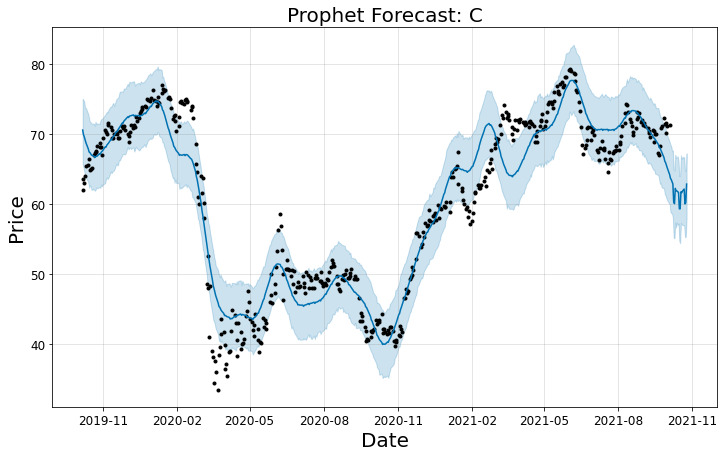

In [80]:
fig = prof_1.plot(forecast, xlabel='Date', ylabel='Pred Value')
ax = fig.gca()
ax.set_title("Prophet Forecast: C", size=20)
ax.set_xlabel("Date", size=20)
ax.set_ylabel("Price", size=20)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

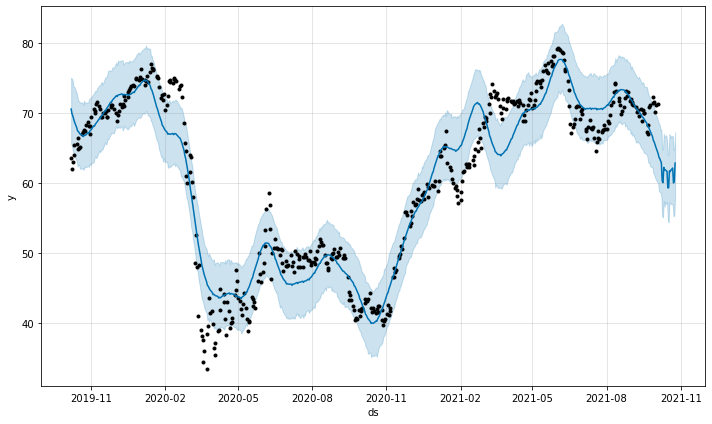

In [55]:
prof_1.plot(forecast)
plt.show()

Thankfully, Prophet has its own cross validation and performance metrics functions to see how well the model performed.

In [56]:
df1_cv = cross_validation(prof_1, initial='30 days', period='1 days', horizon = '14 days')

INFO:prophet:Making 685 forecasts with cutoffs between 2019-11-06 00:00:00 and 2021-09-20 00:00:00


  0%|          | 0/685 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

In [57]:
df1_pm = performance_metrics(df1_cv)

In [58]:
trains=['30 days','60 days','180 days']
tests=['7 days','14 days']

In [59]:
df1_pm.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
8,10 days,880.000420,29.664801,16.054364,0.259822,0.134407,0.269758,0.162564
9,11 days,1362.079199,36.906357,18.723737,0.302054,0.136998,0.301172,0.159909
10,12 days,2035.874931,45.120671,21.635956,0.348034,0.149033,0.322646,0.157982
11,13 days,2617.258088,51.159145,24.189050,0.387398,0.150341,0.338857,0.158535
12,14 days,3476.654823,58.963165,26.983881,0.430317,0.170637,0.349337,0.153166


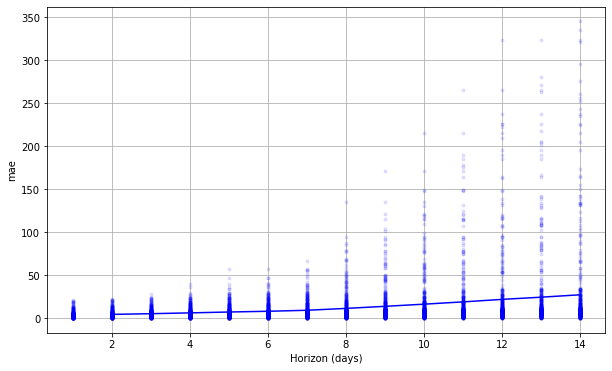

In [60]:
fig = plot_cross_validation_metric(df1_cv, metric='mae')

## STONKS (Again)!!!

Just like in the ARIMA notebook, I want to test a number of train-test splits with Prophet. Since it works a little different from ARIMA, the code will be a little different, but still borrowing a lot. Here, we can import our stock symbols, and clean them up.

In [61]:
sp_500=pd.read_csv('Data/constituents_csv.csv')
nsdq=pd.read_csv('Data/nasdaq.csv')
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

Again, we'll be doing the same things we did in the ARIMA notebook to make the data model-friendly. Like changing the names of the columns in the Dow dataframe.

In [62]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [63]:
nsdq.head()

,Unnamed: 0,Symbol,Company Name
0,1,AAL,"American Airlines Group, Inc."
1,2,AAME,Atlantic American Corporation
2,3,AAOI,"Applied Optoelectronics, Inc."
3,4,AAON,"AAON, Inc."
4,5,AAPL,Apple Inc.


In [64]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

In [65]:
len(nsdq)

1701

Again, like the ARIMA notebook, this code is to find all the bad stocks (delisted) in the NASDAQ csv file. I've hashed it out because I saved the csv, so it should work just fine. But I kept the code in case I run this in the future and it doesn't work.

In [66]:
#no_data=[]
#for each in nsdq['Symbol']:
#    x=yf.Ticker(each)
#    df=x.history(period='1d')
#    if len(df)==0:
#        no_data.append(each)

In [67]:
#len(no_data)

In [68]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [69]:
#nsdq = nsdq.drop(labels=nd_index,drop=True, axis=0)
#nsdq.reset_index()

In [70]:
#nsdq.to_csv("/Users/Daniel/Documents/Flatiron/Capstone/Project/nasdaq.csv")

In [71]:
def tt_test_p (asset,train_val,test_val):
    """This function will take in a financial asset (stock, etf, as a string) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run prophet models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='1y')
    print("Processing: ",stock)
    prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    future = prof_1.make_future_dataframe(periods=14)
    forecast = prof_1.predict(future)
    for train_val in trains:
        for test_val in tests:
            df1_cv = cross_validation(prof_1, initial=train_val, period='1 days', horizon = test_val)
            df1_pm = performance_metrics(df1_cv)
            print('Training: ', train_val)
            print('Testing: ', test_val)
            print (df1_pm.tail())             

    return forecast

In [72]:
cols2=['Symbol','Train_Len','Test_Len','MAE','RMSE']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

,index,Symbol,Train_Len,Test_Len,MAE,RMSE


In [73]:
results_CAT=tt_test_p('CAT',trains,tests)

Processing:  yfinance.Ticker object <CAT>


INFO:prophet:Making 328 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-27 00:00:00


  0%|          | 0/328 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   393.826729  19.845068  13.733669  0.068111  0.048071  0.069902   
3  4 days   767.807019  27.709331  18.848090  0.094330  0.065925  0.099290   
4  5 days  1415.363300  37.621314  24.821818  0.125585  0.077906  0.131668   
5  6 days  1682.460553  41.017808  28.591246  0.144428  0.091724  0.151010   
6  7 days  2326.310147  48.231837  34.364351  0.173686  0.106167  0.186614   

   coverage  
2  0.244444  
3  0.172566  
4  0.141593  
5  0.106667  
6  0.111111  


INFO:prophet:Making 321 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-20 00:00:00


  0%|          | 0/321 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  16252.421719  127.484986   76.756961  0.395059  0.193733   
9  11 days  25085.168620  158.382981   91.568774  0.474437  0.222377   
10 12 days  39082.096101  197.691922  112.253242  0.585944  0.251555   
11 13 days  46846.177625  216.439778  127.318503  0.663573  0.291393   
12 14 days  54281.676575  232.984284  142.188001  0.739643  0.299076   

       smape  coverage  
8   0.372786  0.035714  
9   0.414708  0.044702  
10  0.464379  0.043280  
11  0.516029  0.037609  
12  0.566326  0.042857  


INFO:prophet:Making 298 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-27 00:00:00


  0%|          | 0/298 [00:00<?, ?it/s]

INFO:prophet:Making 291 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-20 00:00:00


Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   304.681679  17.455133  12.812169  0.061514  0.047855  0.060599   
3  4 days   561.412826  23.694152  17.121930  0.082541  0.061004  0.080628   
4  5 days   949.662921  30.816601  21.766964  0.105595  0.073292  0.100379   
5  6 days  1151.540000  33.934348  24.968818  0.120894  0.083125  0.115903   
6  7 days  1662.396787  40.772500  30.062087  0.145822  0.098633  0.145217   

   coverage  
2  0.252427  
3  0.169903  
4  0.146341  
5  0.112745  
6  0.122549  


  0%|          | 0/291 [00:00<?, ?it/s]

INFO:prophet:Making 178 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-27 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days   9951.075632   99.755078   63.265007  0.312077  0.179171   
9  11 days  14458.766186  120.244610   72.704981  0.359765  0.213200   
10 12 days  20950.876568  144.744176   85.022364  0.421395  0.225430   
11 13 days  25232.008963  158.845865   96.175320  0.475322  0.243257   
12 14 days  29964.801622  173.103442  108.229903  0.534614  0.272342   

       smape  coverage  
8   0.299238  0.039068  
9   0.331877  0.045579  
10  0.371832  0.049930  
11  0.419230  0.043011  
12  0.469650  0.047369  


  0%|          | 0/178 [00:00<?, ?it/s]

INFO:prophet:Making 171 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-20 00:00:00


Training:  180 days
Testing:  7 days
  horizon         mse       rmse        mae      mape     mdape     smape  \
2  3 days  199.061817  14.108927  11.113313  0.050898  0.047677  0.050483   
3  4 days  312.710640  17.683626  14.049975  0.064337  0.056516  0.063733   
4  5 days  442.397327  21.033243  16.541338  0.075889  0.061725  0.074854   
5  6 days  477.761631  21.857759  17.884031  0.082206  0.071555  0.081288   
6  7 days  553.844891  23.533909  19.999659  0.092134  0.087262  0.091518   

   coverage  
2  0.240000  
3  0.176000  
4  0.137097  
5  0.146341  
6  0.130081  


  0%|          | 0/171 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days  1838.743281  42.880570  34.876979  0.160688  0.135200  0.156204   
9  11 days  2339.584987  48.369257  38.940542  0.179484  0.160117  0.174298   
10 12 days  3024.958230  54.999620  44.216598  0.203546  0.174913  0.198676   
11 13 days  3254.479445  57.048045  47.296610  0.217899  0.193601  0.214791   
12 14 days  3352.189766  57.898098  49.487344  0.228566  0.216339  0.228108   

    coverage  
8   0.040261  
9   0.051406  
10  0.046637  
11  0.030222  
12  0.037472  


In [74]:
results_MMM=tt_test_p('MMM',trains,tests)

Processing:  yfinance.Ticker object <MMM>


INFO:prophet:Making 328 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-27 00:00:00


  0%|          | 0/328 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   184.835762  13.595432   8.881825  0.050038  0.029606  0.051369   
3  4 days   389.264461  19.729786  12.381405  0.070130  0.038446  0.073487   
4  5 days   802.462423  28.327768  16.980404  0.096780  0.049249  0.104213   
5  6 days  1052.953965  32.449252  20.120609  0.114742  0.054587  0.122210   
6  7 days  1674.344863  40.918759  25.782843  0.147112  0.067477  0.156554   

   coverage  
2  0.231111  
3  0.176991  
4  0.168142  
5  0.137778  
6  0.084444  


INFO:prophet:Making 321 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-20 00:00:00


  0%|          | 0/321 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  12858.819590  113.396735   63.918872  0.367010  0.123288   
9  11 days  20190.626745  142.093725   79.338902  0.456230  0.116180   
10 12 days  32810.168794  181.135774   98.985288  0.570031  0.117441   
11 13 days  41314.934111  203.260754  110.643264  0.636884  0.175492   
12 14 days  51024.965989  225.887065  122.347801  0.704040  0.169529   

       smape  coverage  
8   0.392567  0.065584  
9   0.457860  0.045912  
10  0.494753  0.043971  
11  0.501545  0.048643  
12  0.511070  0.046753  


INFO:prophet:Making 298 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-27 00:00:00


  0%|          | 0/298 [00:00<?, ?it/s]

Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   121.681996  11.030956   7.596895  0.041977  0.025474  0.041998   
3  4 days   246.689309  15.706346  10.354444  0.057440  0.035933  0.057419   
4  5 days   481.510943  21.943358  13.864142  0.077443  0.043174  0.077222   
5  6 days   655.446637  25.601692  16.377068  0.091667  0.051152  0.091689   
6  7 days  1091.871759  33.043483  20.919872  0.117276  0.061049  0.118719   

   coverage  
2  0.257282  
3  0.194175  
4  0.185366  
5  0.147059  
6  0.098039  


INFO:prophet:Making 291 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-20 00:00:00


  0%|          | 0/291 [00:00<?, ?it/s]

INFO:prophet:Making 178 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-27 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
8  10 days   7589.454591   87.117476  48.967707  0.277328  0.092981  0.301330   
9  11 days  11458.792418  107.045749  59.366433  0.336604  0.100877  0.354143   
10 12 days  17394.797983  131.889340  71.406979  0.405331  0.122417  0.384975   
11 13 days  21678.242967  147.235332  78.857254  0.447474  0.142268  0.385971   
12 14 days  28084.421836  167.584074  88.545484  0.502882  0.164758  0.394607   

    coverage  
8   0.078136  
9   0.048146  
10  0.050696  
11  0.051613  
12  0.050251  


  0%|          | 0/178 [00:00<?, ?it/s]

INFO:prophet:Making 171 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-20 00:00:00


Training:  180 days
Testing:  7 days
  horizon         mse       rmse        mae      mape     mdape     smape  \
2  3 days   42.414092   6.512610   5.111257  0.026289  0.019866  0.026091   
3  4 days   65.655138   8.102786   6.536079  0.033598  0.029739  0.033358   
4  5 days   87.776113   9.368891   7.768848  0.039869  0.037282  0.039694   
5  6 days  108.000944  10.392350   8.535606  0.043743  0.037283  0.043556   
6  7 days  157.422495  12.546812  10.106888  0.051778  0.042028  0.051427   

   coverage  
2  0.312000  
3  0.224000  
4  0.209677  
5  0.186992  
6  0.138211  


  0%|          | 0/171 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days   435.199986  20.861447  16.805210  0.085815  0.071838  0.084276   
9  11 days   546.413098  23.375481  19.057961  0.097457  0.080143  0.095462   
10 12 days   682.094012  26.116930  21.123520  0.107903  0.088445  0.106322   
11 13 days   833.566638  28.871554  22.918357  0.116880  0.094840  0.116004   
12 14 days  1010.052368  31.781321  24.778388  0.126505  0.099861  0.125402   

    coverage  
8   0.092570  
9   0.059237  
10  0.062349  
11  0.067632  
12  0.073821  


In [76]:
results_AXP=tt_test_p('AXP',trains,tests)

Processing:  yfinance.Ticker object <AXP>


INFO:prophet:Making 328 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-27 00:00:00


  0%|          | 0/328 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   291.640148  17.077475  11.862746  0.089245  0.056592  0.093292   
3  4 days   597.917419  24.452350  16.530760  0.125809  0.074312  0.136203   
4  5 days  1107.158797  33.273996  22.572213  0.174103  0.098510  0.190793   
5  6 days  1676.606156  40.946381  27.550240  0.213372  0.114940  0.237096   
6  7 days  3035.878854  55.098810  35.628477  0.276204  0.138693  0.304665   

   coverage  
2  0.204444  
3  0.172566  
4  0.154867  
5  0.151111  
6  0.128889  


INFO:prophet:Making 321 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-20 00:00:00


  0%|          | 0/321 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  16220.734560  127.360648   77.712882  0.608281  0.230335   
9  11 days  24341.757870  156.018454   94.193805  0.739740  0.251692   
10 12 days  35487.560485  188.381423  113.922623  0.897458  0.272199   
11 13 days  47341.237550  217.580416  131.427402  1.034631  0.298860   
12 14 days  65188.417189  255.320225  150.981503  1.185082  0.328717   

       smape  coverage  
8   0.511174  0.057792  
9   0.548477  0.059578  
10  0.592631  0.063348  
11  0.625959  0.057061  
12  0.651470  0.044805  


INFO:prophet:Making 298 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-27 00:00:00


  0%|          | 0/298 [00:00<?, ?it/s]

Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   221.927513  14.897232  10.455852  0.075964  0.052047  0.076775   
3  4 days   446.148282  21.122222  14.283972  0.104782  0.068526  0.107176   
4  5 days   795.735212  28.208779  18.992941  0.141147  0.083958  0.142015   
5  6 days  1195.882149  34.581529  23.078776  0.172818  0.104140  0.177615   
6  7 days  2166.796589  46.548862  29.838985  0.224413  0.117400  0.242674   

   coverage  
2  0.228155  
3  0.189320  
4  0.170732  
5  0.166667  
6  0.142157  


INFO:prophet:Making 291 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-20 00:00:00


  0%|          | 0/291 [00:00<?, ?it/s]

INFO:prophet:Making 178 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-27 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  10643.978243  103.169658   61.979058  0.471005  0.215881   
9  11 days  15633.355594  125.033418   74.228663  0.564731  0.215881   
10 12 days  22767.452833  150.888876   89.182021  0.679643  0.234566   
11 13 days  31367.737875  177.109395  104.067819  0.793900  0.274723   
12 14 days  46211.316072  214.968175  122.852571  0.936931  0.254622   

       smape  coverage  
8   0.422960  0.070358  
9   0.455652  0.068261  
10  0.495269  0.069901  
11  0.532984  0.063082  
12  0.566781  0.049549  


  0%|          | 0/178 [00:00<?, ?it/s]

INFO:prophet:Making 171 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-20 00:00:00


Training:  180 days
Testing:  7 days
  horizon         mse       rmse        mae      mape     mdape     smape  \
2  3 days   77.646198   8.811708   7.194170  0.045245  0.039817  0.045254   
3  4 days  118.592358  10.890012   8.793331  0.055309  0.044146  0.055501   
4  5 days  164.529157  12.826892  10.230107  0.064450  0.049038  0.064965   
5  6 days  195.046767  13.965914  11.048415  0.069567  0.054344  0.070323   
6  7 days  247.227281  15.723463  12.505834  0.078525  0.071719  0.079639   

   coverage  
2  0.280000  
3  0.264000  
4  0.258065  
5  0.252033  
6  0.219512  


  0%|          | 0/171 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days   669.153279  25.867997  20.850291  0.131336  0.099295  0.133422   
9  11 days   867.990682  29.461682  23.273433  0.146251  0.111331  0.150371   
10 12 days  1091.288709  33.034659  25.632195  0.160864  0.109396  0.168036   
11 13 days  1263.582871  35.546911  27.459407  0.172160  0.112949  0.181478   
12 14 days  1415.232748  37.619579  29.056122  0.181877  0.139318  0.192545   

    coverage  
8   0.105522  
9   0.109739  
10  0.117369  
11  0.112332  
12  0.086073  


In [ ]:
results_AAPL=tt_test_p('AAPL',trains,tests)

In [ ]:
results_AMGN=tt_test_p('AMGN',trains,tests)

After looking over these results, it seems unlike ARIMA, Prophet likes the 180/7 split. 

In [ ]:
stocks=['MMM','AXP','AMGN','AAPL','CAT']
cv_cols=['horizon','mse','rmse','mae','mape','mdape','smape','coverage']

In [ ]:
df_y=pd.DataFrame(columns=cv_cols)
for each in stocks:
    stock = yf.Ticker(each)
    df1=stock.history(period='1y')
    print("Processing: ",each)
    prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    df1_cv = cross_validation(prof_1, initial='30 days', period='1 days', horizon = '14 days')
    df1_pm = performance_metrics(df1_cv)
    df_ph=df1_pm.sort_values(by=['mae']).head(2)
    df_y=pd.concat([df_y,df_ph])

In [ ]:
df_y

### Putting it all together

So let's make us a function! Ultimately, we'll want it to be able to select the best of 4 stocks input by the user. As always, let's start simple.

In [ ]:
results_AMGN.tail()

In [ ]:
pred_cols=['ds','yhat']

In [ ]:
AMGN_preds=results_AMGN[pred_cols]

In [ ]:
AMGN_preds.tail()

In [ ]:
AMGN_preds=AMGN_preds.tail(21)

In [ ]:
AMGN_preds.head()

In [ ]:
AMGN_preds.reset_index(level=0, drop=True,inplace=True)

In [ ]:
AMGN_preds.head()

In [ ]:
AMGN_preds['yhat'][20]

In [ ]:
AMGN_preds['yhat'][0]

In [ ]:
change_percent=((AMGN_preds['yhat'][20]-AMGN_preds['yhat'][0])/AMGN_preds['yhat'][0])*100

In [ ]:
change_percent=round(change_percent,3)

In [ ]:
change_percent

Now let's put this together into a simple function. It will take the yhat predictions and calculate the percentage return.

In [ ]:
def pct_change(df):
    """This function will take a Prophet forecast dataframe and quickly calculate the percentage change.
    One that has been produced from the earlier Prophet function"""
    df1=df['yhat']
    df1=df1.tail(14)
    df1.reset_index(level=0, drop=True,inplace=True)
    change=((df1[13]-df1[0])/df1[0])*100
    change=round(change, 2)
    if change >0:
        print(f"According to the model, you stand to gain {change}% over the next 14 days")
    else:
        change_abs=abs(change)
        print(f"According to the model, you stand to lose {change_abs}% over the next 14 days")
    return None

In [ ]:
pct_change(results_AAPL)

In [ ]:
pct_change(results_AXP)

In [ ]:
pct_change(results_MMM)

In [ ]:
pct_change(results_CAT)

Now, let's create a function that will run through the Prophet process, and return the forecast.

In [ ]:
def fcast(stock):
    """This function will take a stock( as a string) and perform all the necessary changes to the data to allow Prophet to model
    it and return the forecast dataframe"""
    stock=stock.upper() #make sure the symbol is in uppercase
    prof=Prophet(daily_seasonality=True, yearly_seasonality=True)
    stonk = yf.Ticker(stock)
    df1=stonk.history(period='1y')
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof.fit(df1)
    future = prof.make_future_dataframe(periods=14)
    forecast = prof.predict(future)
    #The next 2 lines are disabled for the final function, but I wanted a few graphs.
#    prof.plot(forecast)
 #   plt.show()
    return forecast

In [ ]:
HAL=fcast('HAL')

In [ ]:
HAL.head()

In [ ]:
MMM=fcast('MMM')

In [ ]:
AXP=fcast('AXP')

Now the final piece: taking in 4 stocks from the user, running them through the previous functions, and letting us know which one stands to gain the most.

In [ ]:
def pred_4():
    """This function will prompt the user to input 4 different stock/ETF symbols. It will then use Prophet 
    to forecast the next 14 days of the stock price, and return the values (in percent) of potential gain and loss."""
    stocks=[]
    pcts=[]
    stock1,stock2,stock3,stock4=input("Enter 4 stock symbols: ").split(",")
    stocks=[stock1,stock2,stock3,stock4]
    print("Working...")
    for stock in stocks:
        stock=stock.upper()
        df=fcast(stock)
        df1=df['yhat']
        df1=df1.tail(14)
        df1.reset_index(level=0, drop=True,inplace=True)
        change=((df1[13]-df1[0])/df1[0])*100
        change=round(change, 2)
        pcts.append(change)
    for i in range(0,4):
        print(f"Stock: {stocks[i].upper()}")
        print(f"Percent Change: {pcts[i]}")
    maxp=pcts.index(max(pcts))
    print()
    print(f'According to the model, {stocks[maxp].upper()} has the highest upside.')
    print("\n" * 3)
    print('FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.') 
    print('The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.')
    return None
    

In [ ]:
pred_4()

# Conclusion:

I like to call this the KISSSS (the Keep it Simple Stock Selector-The Last 'S' is a typo), and it's true to its name. It's simple, it provides an answer that investors can use to make their decisions. Now as the disclaimer states, this should not be the only factor used in making any investment decision; but for someone that doesn't want to do a lot of research into their stock purchases, this will fit them just fine.

Personaly, I like Prophet much better than ARIMA. It provided much better numbers and it was built to predict time series that were more random than what ARIMA was built for.